### Example of using the spherical_opt package and the llh_service to reconstruct an event

In [1]:
import pickle
import json
import math
import pkg_resources
from multiprocessing import Process

import numpy as np
from matplotlib import pyplot as plt

from freedom.llh_service.llh_service import LLHService
from freedom.llh_service.llh_client import LLHClient

from spherical_opt import spherical_opt


In [2]:
data_fname = '/home/atfienberg/freedomDataCopy/public_for_aaron/test_events.pkl'

with open(data_fname, 'rb') as f:
    events = pickle.load(f)
test_idx = 2071
    
event = events[test_idx]

In [3]:
allowed_DOMs = np.load(pkg_resources.resource_filename('freedom', 'resources/allowed_DOMs.npy'))
ndoms = len(allowed_DOMs)

### llh service configurations

One for plotting, one for fitting

In [4]:
crs_service_conf = {
        "req_addr": "tcp://127.0.0.1:12347",
        "ctrl_addr": "tcp://127.0.0.1:12348",
        "poll_timeout": 1,
        "flush_period": 1,
        "n_hypo_params": 8,
        "n_hit_features": 9,
        "n_evt_features": ndoms*4,
        "batch_size" : {
          "n_hypos": 12,
          "n_observations": 500 
        },
        "send_hwm": 10000,
        "recv_hwm": 10000,
        "hitnet_file": "/home/atfienberg/freedomDataCopy/public_for_aaron/HitNet_ranger_14_Jul_2020-08h03/epoch_32_model.hdf5",
        "domnet_file": "/home/atfienberg/freedomDataCopy/public_for_aaron/DOMNet_reduced_09_Jul_2020-15h13/epoch_30_model.hdf5",
        "ndoms": ndoms
}

plot_service_conf = crs_service_conf.copy()
plot_service_conf['req_addr'] = 'tcp://127.0.0.1:12349'
plot_service_conf['ctrl_addr'] = 'tcp://127.0.0.1:12350'
plot_service_conf['batch_size'] = {"n_hypos": 250, "n_observations": 2000}

In [5]:
# start the service in a separate process
def start_service(params, gpu_id):
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = f'{gpu_id}'
    
    with LLHService(**params) as serv:
        print('starting work loop...')
        serv.start_work_loop()
        
    print('done')

crs_proc = Process(target=start_service, args=(crs_service_conf, 0))
crs_proc.start()
plot_proc = Process(target=start_service, args=(plot_service_conf, 1))
plot_proc.start()

starting work loop...
starting work loop...
Received die command... flushing and exiting
cleaning up
done
Received die command... flushing and exiting
cleaning up
done


### Construct the clients

In [6]:
%%time
# client for fitting
client = LLHClient(
                    ctrl_addr=crs_service_conf["ctrl_addr"],
                    conf_timeout=60000
                  )

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 4.21 s


Define some ranges for searching and plotting

In [7]:
init_pos_range = 50

time_range = (-1000, 0)

log_energy_range = [-1, 2]

In [8]:
def initial_box(hits, charge_ind=4, n_params=8):
    ''' returns initial box limits for each dimension
    in the form of a n_params x 2 table
    '''
    
    # charge weighted positions, time
    hit_avgs = np.average(hits, weights=hits[:, charge_ind], axis=0)[:4]
    
    limits = np.empty((n_params, 2), np.float32)
    
    # x, y, z range from average - init_pos_range to average + average + init_pos_range
    limits[:3, 0] = hit_avgs[:3] - init_pos_range
    limits[:3, 1] = hit_avgs[:3] + init_pos_range
    
    # time is time average + time_range[0] to average + time_range[1]
    limits[3, 0] = hit_avgs[3] + time_range[0]
    limits[3, 1] = hit_avgs[3] + time_range[1]
    
    fill_angle_energy_limits(limits)
 
    return limits


def fill_angle_energy_limits(limits):
    # azimuth from 0 to 2pi
    limits[4] = [0, 2*math.pi]
    
    # zenith from 0 to pi
    limits[5] = [0, math.pi]
    
    # log energies from log_energy_range
    limits[6:, 0] = log_energy_range[0]
    limits[6:, 1] = log_energy_range[1]
    
    
def transform_params(params, energies=False):
    ''' transforms params following random generation
    specifically: turns log energy into energy, 
    moves angular parameters into their proper ranges 
    
    transformations are conducted in place
    '''
    
    # handle zeniths that have been moved out of range
    azimuths = params[:, 4]
    zeniths = params[:, 5]
    
    # handle zeniths that have been moved above Pi
    high_zen_inds = zeniths > math.pi
    zeniths[high_zen_inds] = 2*math.pi - zeniths[high_zen_inds]
    azimuths[high_zen_inds] += math.pi
    
    # handle zeniths that have been moved below 0 
    low_zen_inds = zeniths < 0
    zeniths[low_zen_inds] = np.abs(zeniths[low_zen_inds])
    azimuths[low_zen_inds] += math.pi
        
    # keep azimuths in range
    azimuths[:] = np.remainder(azimuths, 2*math.pi)

    if energies:
        params[:, 6:] = np.power(10, params[:, 6:])
    
    return params

### Opt functions

In [9]:
NAN_REPLACE_VAL = 1e10

def nan_replace(nll):
    # replace nans with valid, large values 
    nll[np.isnan(nll)] = NAN_REPLACE_VAL

    return nll

def get_batch_closure(client, event):
    def eval_llh(params):
        llhs = client.eval_llh(event['hits'], event['doms'][allowed_DOMs], params)
        
        llhs = np.atleast_1d(llhs)
        
        llhs = nan_replace(llhs)
        
        clipped_params = np.copy(params)
        
        for energy_ind in [6, 7]:
            energies = clipped_params[:, energy_ind]
            neg_inds = energies <= 0
            
            llhs[neg_inds] = NAN_REPLACE_VAL
            energies[neg_inds] = 1
            llhs[np.log10(energies) <= log_energy_range[0]] = NAN_REPLACE_VAL
            llhs[np.log10(energies) >= log_energy_range[1]] = NAN_REPLACE_VAL
            
        return llhs
    
    return eval_llh

def batch_crs_fit(event, client, rng):
    eval_llh = get_batch_closure(client, event)
    
    box_limits = initial_box(event['hits'])
    
    uniforms = rng.uniform(size=(129, len(event['params'])))

    uniforms = box_limits[:, 0] + uniforms*(box_limits[:,1] - box_limits[:, 0])
    initial_points = transform_params(uniforms, True)
    
    opt_ret = spherical_opt.spherical_opt(
                        func=eval_llh, 
                        method="CRS2", 
                        initial_points=initial_points,
                        spherical_indices=[[4,5]],
                        max_iter=10000,
                        batch_size=12,
                        rand=rng) 
    
    return opt_ret

### All in one results:

In [10]:
rng = np.random.default_rng()

In [11]:
%%time
batch_opt_ret = batch_crs_fit(event, client, rng)

CPU times: user 980 ms, sys: 84 ms, total: 1.06 s
Wall time: 6.68 s


In [12]:
print(batch_opt_ret['n_calls'])
print(batch_opt_ret['nit'])
print(batch_opt_ret['fun'])
print(batch_opt_ret['x'])

7286
364
-177.855
[ 8.71789255e+01 -9.15366828e+01 -4.85306422e+02  9.71927235e+03
  6.16492891e+00  2.31233478e+00  1.72977369e+01  1.21760509e+01]


### Plots

In [13]:
# client optimized for making plots
client = LLHClient(
                    ctrl_addr=plot_service_conf["ctrl_addr"],
                    conf_timeout=60000
                  )

In [14]:
true_params = event['params']

par_names = ['x', 'y', 'z', 'time',
             'azimuth', 'zenith', 
             'cascade energy', 'track energy']

par_pairs = [(0, 1), (0, 2), (1, 2), (3, 2),
             (4, 5), (4, 2), (4, 0), (6, 7)
            ]

gridsize=100
spacings = [np.linspace(true_params[0]-30, true_params[0]+30, gridsize),
            np.linspace(true_params[1]-30, true_params[1]+30, gridsize),
            np.linspace(true_params[2]-30, true_params[2]+30, gridsize),
            np.linspace(true_params[3]-400, true_params[3]+100, gridsize),
            np.linspace(0, 2*math.pi, gridsize),
            np.linspace(0, math.pi, gridsize),
            np.logspace(-1, 3, gridsize),
            np.logspace(-1, 3, gridsize)
           ]

In [15]:
def colorbar(mappable):
    # from https://joseph-long.com/writing/colorbars/
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    cbar.ax.tick_params(labelsize=12)
    return cbar

# utility function to map out a 2d NLL slice
def map_2d(inds, steps, event=event, base_params=event['params']):
    mg = np.meshgrid(*steps)
    
    n_hypotheses = mg[0].size
    
    # param table is a table of hypotheses to evaluate
    # each row contains a value for each of the 8 hypothesis parameters
    param_table = np.repeat(base_params[np.newaxis, :], n_hypotheses, axis=0)

    # load hypotheses to evaluate into the param table
    for ind, coord in zip(inds, mg):
        param_table[:, ind] = coord.flat
        
    return client.eval_llh(event['hits'], event['doms'][allowed_DOMs], param_table).reshape([step.size for step in steps[::-1]])

def plot_2d(inds, steps, true_params, ax, fit_params=None, guess_params=None, 
            event=event, base_params=event['params'], samples=None, 
            limit_z=True, retro=None, spefit=None):
    llh_map = map_2d(inds, steps, event, base_params=base_params)

    llh_min = llh_map[~np.isnan(llh_map)].min()
    
    delta = llh_map - llh_min
    
    delta = np.ma.masked_invalid(delta)
    
    if limit_z:
        im = ax.pcolormesh(*steps, delta, cmap='Spectral', 
                           rasterized=True, linewidth=0,
                           vmin=0, vmax=100)
    else:
        im = ax.pcolormesh(*steps, delta, cmap='Spectral', 
                           rasterized=True, linewidth=0)
    colorbar(im)
    
    mle_y, mle_x = np.unravel_index(np.argmin(llh_map), llh_map.shape)
    
    # place "T" and crosshairs at true parameters
    ax.axvline(true_params[0])
    ax.axhline(true_params[1])
    ax.plot([true_params[0]], [true_params[1]], color='w', marker='$T$', markersize=10)
   
    if samples is None:
        # green F at fit params
        if fit_params is not None:
            ax.plot(*[[fit_params[i]] for i in inds], color='g', marker='$F$', markersize=10)

        # blue star at guess params
        if guess_params is not None:
            ax.plot(*[[guess_params[i]] for i in inds], 'b*')        
            
    else:
        ax.plot(samples[:, inds[0]], samples[:, inds[1]], 'ko', markersize=10, alpha=0.5)
        
    if retro is not None:
        ax.plot(*[[retro[i]] for i in inds], color='b', marker='$R$', markersize=10)
        
    ax.set_xlim(steps[0][0], steps[0][-1])
    ax.set_ylim(steps[1][0], steps[1][-1])

In [16]:
def make_plot(event, opt_ret):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,8))
    plt.subplots_adjust(wspace=0.5)
    plt.subplots_adjust(hspace=0.25)
    
    best_params = opt_ret['x']
    true_params = event['params']
    best_nll = opt_ret['fun']
    nll_at_true = client.eval_llh(event['hits'], event['doms'][allowed_DOMs], true_params)
    nll_at_retro = client.eval_llh(event['hits'], event['doms'][allowed_DOMs], event['retro'])
    
    evt_spacings = spacings
    
    axiter = axes.flat
    for i, ax in enumerate(axiter):
        ind0, ind1 = par_pairs[i]
        grid_spacing = (evt_spacings[ind0], evt_spacings[ind1])
        
        # around fit
        plot_2d((ind0, ind1), grid_spacing, (true_params[ind0], true_params[ind1]), 
                ax, base_params=best_params, fit_params=best_params, 
                event=event, retro=event['retro'],
                limit_z=False)
    
        ax.set_xlabel(par_names[ind0], fontsize=12)
        ax.set_ylabel(par_names[ind1], fontsize=12)
        ax.tick_params(labelsize=12) 
        
        if par_names[ind0].endswith('energy'):
            ax.set_xscale('log')
        if par_names[ind1].endswith('energy'):
            ax.set_yscale('log')

    nll_str = f'\n$-$LLH at true params: {nll_at_true:.2f}'
    nll_str += f'\n$-$LLH at fit: {best_nll:.2f}, retro: {nll_at_retro:.2f}'
    fig.suptitle(f'Test event {test_idx}{nll_str}', fontsize=16)

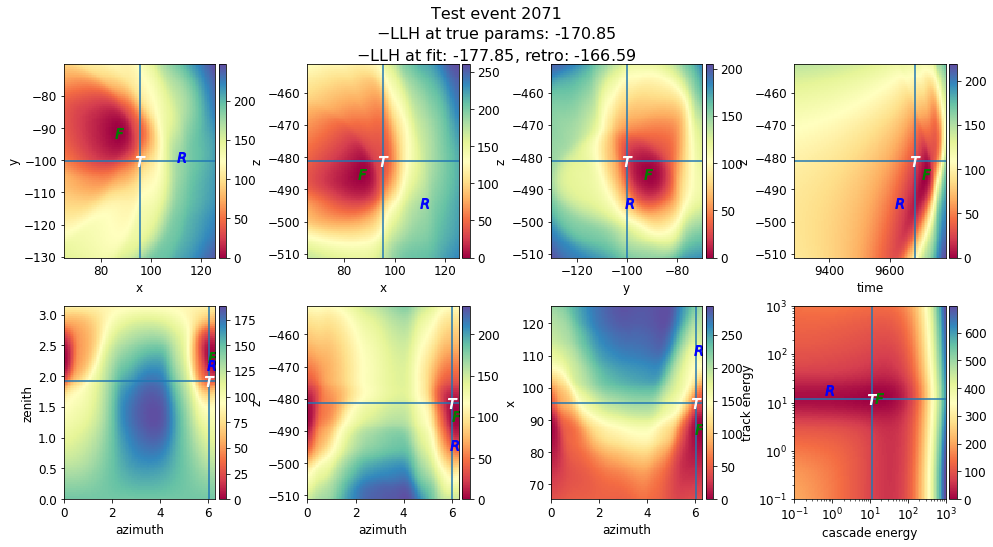

In [17]:
make_plot(event, batch_opt_ret)

In [18]:
# kill the services
import zmq
with zmq.Context.instance().socket(zmq.REQ) as ctrl_sock:
    ctrl_sock.connect(crs_service_conf["ctrl_addr"])
    ctrl_sock.send_string("die")
    crs_proc.join()
    
with zmq.Context.instance().socket(zmq.REQ) as ctrl_sock:
    ctrl_sock.connect(plot_service_conf["ctrl_addr"])
    ctrl_sock.send_string("die")
    plot_proc.join()